# Continuous Control with Deep Deterministic Policy Gradient (DDPG)

---

This Projekt is the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.
Here, an implementation of a Deep Deterministic Policy Gradient (DDPG) Algorithm is provided to solve the Unity Reacher environment.

### 1. Start the Environment

If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/). 

In [1]:
import gym
import random
import torch
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
from itertools import count
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

### 2. Instantiate the Environment and Agent

In [2]:
env = UnityEnvironment(file_name='env/Reacher.x86_64')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [3]:
# Create Agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=10)

### 3. Train the Agent with DDPG

In [4]:
def ddpg(n_episodes=1000, print_every=100):
    """DDQN Algorithm.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        print_every (int): frequency of printing information throughout iteration """
    
    scores = []
    running_mean = []
    scores_deque = deque(maxlen=print_every)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        
        while True:
            action = agent.act(state)          # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done) # take step with agent (including learning)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        
        #introduces again a Experience Learning step - to fasten up training
        agent.learn_from_experience()
        
        scores_deque.append(score)       # save most recent score
        scores.append(score)             # save most recent score
        running_mean.append(np.mean(scores_deque))
        print('\rEpisode {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, np.mean(scores_deque),score), end="")
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores, running_mean

In [5]:
scores, running_mean = ddpg(n_episodes = 500)

Episode 100	Average Score: 3.24
Episode 200	Average Score: 21.57
Episode 300	Average Score: 28.81
Episode 318	Average Score: 30.05	Current Score: 37.07
Environment solved in 318 episodes!	Average Score: 30.05


### Plot Figure

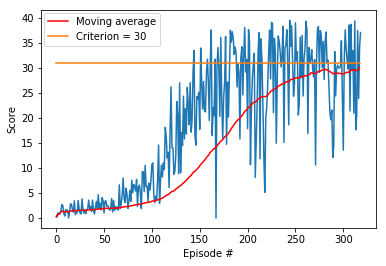

In [30]:
fig = plt.figure()

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(len(scores)), running_mean, label='Moving average', color='red')
plt.plot(np.arange(len(scores)), np.ones(len(scores))+30, label='Criterion = 30')
plt.legend(bbox_to_anchor=(0.01, 0.99), loc=2, borderaxespad=0.)
fig.savefig('result.png')
plt.show()


### 4. Watch a Smart Agent!

In [22]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations
while True:
    action = agent.act(state, add_noise=False)
    env_info = env.step(action)[brain_name]
    if env_info.local_done[0]:
        break 

env.close()

### Next steps

- Prioritized experience replay
